## **Анализ результатов A/B теста**


#### **Описание проекта**
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 

#### **Описание данных**

Данные для первой части:

Файл `/datasets/hypothesis.csv`

* `Hypothesis` — краткое описание гипотезы;
* `Reach` — охват пользователей по 10-балльной шкале;
* `Impact` — влияние на пользователей по 10-балльной шкале;
* `Confidence` — уверенность в гипотезе по 10-балльной шкале;
* `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы.


Данные для второй части:

Файл `/datasets/orders.csv`

* `transactionId` — идентификатор заказа;
* `visitorId` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.


Файл `/datasets/visitors.csv`

* `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста


### **Импорт библиотек и настроек**

In [1]:
# Импорт бибилиотек
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from pandas.plotting import register_matplotlib_converters
import warnings
import matplotlib.ticker as ticker
from scipy import stats as st
import numpy as np
import math as mth


# настройка на большой принт
pd.set_option("display.max_rows", None)


from pylab import rcParams
rcParams['figure.figsize'] = 8, 4


### **Чтение файлов с данными**

In [2]:
try: 
    os.path.exists('/datasets/hypothesis.csv')
    os.path.exists('/datasets/orders.csv')
    os.path.exists('/datasets/visitors.csv')

    hypothesis_raw = pd.read_csv('/datasets/hypothesis.csv')
    orders_raw = pd.read_csv('/datasets/orders.csv')
    visitors_raw = pd.read_csv('/datasets/visitors.csv')
except:
    hypothesis_raw = pd.read_csv('datasets/hypothesis.csv')
    orders_raw = pd.read_csv('datasets/orders.csv')
    visitors_raw = pd.read_csv('datasets/visitors.csv')

hypothesis = hypothesis_raw.copy()
orders = orders_raw.copy()
visitors = visitors_raw.copy()

### **Предобработка данных**

#### **1. Файл `/datasets/hypothesis.csv`***

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


#### **2. Файл `/datasets/orders.csv`**

In [5]:
def df_first_glance(df):
    print('Пять рандомных строк:')
    display(df.sample(5))
    print('\n\n\n')
    print('Информация по датафрейму: \n')
    display(df.info())
    print('\n\n\n')
    print('Подсчет пропусков:')
    display(df.isna().sum())
    print('\n\n\n')
    print('Подсчет дубликатов:')
    display('Колличество очевидных дубликатов равно {:}'.format(df.duplicated().sum()))


In [6]:
df_first_glance(orders)

Пять рандомных строк:


,transactionId,visitorId,date,revenue,group
856,2318242783,1634934899,2019-08-27,770,B
633,4077952433,178249104,2019-08-20,16950,A
822,3900298739,1539796403,2019-08-27,2355,A
1039,1853671858,1859207151,2019-08-10,6645,A
434,1215410543,3994425631,2019-08-25,1575,B






Информация по датафрейму: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None





Подсчет пропусков:


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64





Подсчет дубликатов:


'Колличество очевидных дубликатов равно 0'

In [7]:
# Поменяем тип данных в `date`
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

Посмотрим, есть ли пользователи, которые участвовали и в А и В группах:

In [8]:
# всего строчек заказов

len(orders[orders['group'] == 'A']) + len(orders[orders['group'] == 'B'])


1197

In [9]:
# Посмотрим, есть ли пересечение А и В
pd.Series(orders[orders['group'] == 'A']['visitorId'].unique()).isin(pd.Series(orders[orders['group'] == 'B']['visitorId'].unique())).sum()

58

In [10]:
# вычленим visitorId, которые пересекаются:
AinB_and_BinA = set(orders[orders['group'] == 'A']['visitorId']).intersection(set(orders[orders['group'] == 'B']['visitorId']))
len(AinB_and_BinA)

58

In [11]:
# обновим orders
orders = orders[orders['visitorId'].isin(AinB_and_BinA) == False]
orders.reset_index(drop=True, inplace=True)
len(orders)

1016

In [12]:
# Посчитаем сколько строк удалили: 
print('Всего строк из датафрейма удалено:', len(orders_raw) - len(orders))
print(f'В процентах строк из датафрейма удалено: {((len(orders_raw) - len(orders)) / len(orders_raw)*100):.2f}%')

Всего строк из датафрейма удалено: 181
В процентах строк из датафрейма удалено: 15.12%


Мы удалили строки с заказами  от пользователей, которые попали в группу A и B, но есть еще датафрейм с посещениями, мы можем сказать, что, пользователи, совершившие покупки как минимум совершали одно посещение, а для более глубокого анализа не хватает данных, поэтому посчитаем, сколько посещений было по дням:  

In [13]:
wrong_orders = orders_raw[orders_raw['visitorId'].isin(AinB_and_BinA) == True]
wrong_orders.reset_index(drop=True, inplace=True)
A_visits_deleted = wrong_orders[wrong_orders['group'] == 'A'].groupby('date')['transactionId'].count().sort_values(ascending=False).reset_index()
B_visits_deleted = wrong_orders[wrong_orders['group'] == 'B'].groupby('date')['transactionId'].count().sort_values(ascending=False).reset_index()


In [14]:
df_deleted_visits = A_visits_deleted.merge(B_visits_deleted, on = 'date', how='outer')
df_deleted_visits.columns = ['date', 'group_A', 'group_B']

Соберем все в одну таблицу и посмотрим долю посещений по дням:

In [15]:
v_test_a = visitors[visitors['group'] == 'A'].groupby(['date']).agg(visitors_A=('visitors', 'sum')).reset_index()
v_test_b = visitors[visitors['group'] == 'B'].groupby(['date']).agg(visitors_B=('visitors', 'sum')).reset_index()
df_deleted_visits = df_deleted_visits.merge(v_test_a, on = 'date')
df_deleted_visits = df_deleted_visits.merge(v_test_b, on = 'date')
df_deleted_visits['proportion_A'] = round((df_deleted_visits['group_A'] / df_deleted_visits['visitors_A'])*100, 2)
df_deleted_visits['proportion_B'] = round((df_deleted_visits['group_B'] / df_deleted_visits['visitors_B'])*100, 2)
df_deleted_visits

,date,group_A,group_B,visitors_A,visitors_B,proportion_A,proportion_B
0,2019-08-14,7.0,9.0,735,746,0.95,1.21
1,2019-08-22,6.0,4.0,609,650,0.99,0.62
2,2019-08-04,5.0,3.0,717,770,0.70,0.39
3,2019-08-29,5.0,5.0,577,531,0.87,0.94
4,2019-08-27,5.0,5.0,711,720,0.70,0.69
5,2019-08-23,5.0,2.0,468,546,1.07,0.37
6,2019-08-09,5.0,6.0,617,610,0.81,0.98
7,2019-08-15,5.0,5.0,628,544,0.80,0.92
8,2019-08-12,5.0,4.0,595,543,0.84,0.74
9,2019-08-17,4.0,1.0,412,421,0.97,0.24


Теперь можно сделать вывод, что, в данной ситуации, не имея знаний о том, сколько пользователи, попавшие в группы А и B совершили посещений, мы можем игнорировать их посещения в датафрейме `visitors`, так как их доля посещений по дням меньше или около `1%`. Принимаем решение оставить внесенные изменения в датафрейм `orders` и не вносить изменения в датафрейм `visitors`.

#### **3. Файл `/datasets/visitors.csv`**

In [16]:
df_first_glance(visitors)

Пять рандомных строк:


,date,group,visitors
26,2019-08-27,A,711
41,2019-08-11,B,721
40,2019-08-10,B,369
5,2019-08-06,A,667
29,2019-08-30,A,490






Информация по датафрейму: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None





Подсчет пропусков:


date        0
group       0
visitors    0
dtype: int64





Подсчет дубликатов:


'Колличество очевидных дубликатов равно 0'

In [17]:
#Поменяем тип данных в `date`
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

### **Часть 1. Приоритизация гипотез.**

В файле `/datasets/hypothesis.csv` 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами `Reach`, `Impact`, `Confidence`, `Effort`.


Задача:

* Примените фреймворк `ICE` для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
* Примените фреймворк `RICE` для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
* Укажите, как изменилась приоритизация гипотез при применении `RICE` вместо `ICE`. Объясните, почему так произошло.

Гипотезы: 

0. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
1. Запустить собственную службу доставки, что сократит срок доставки заказов
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3. Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар
4. Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей
5. Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов
6. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
7. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
8. Запустить акцию, дающую скидку на товар в день рождения


In [19]:
pd.set_option('display.max_colwidth', 0)
hypothesis['ICE'] = round(hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'], 1)
hypothesis.sort_values('ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


In [20]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis.sort_values('RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


#### Вывод
По методу `ICE` топ-3 гипотезы под номерами `8`, `0`, `7`, а по методу `RICE` топ-3 гипотезы под номерами `7`, `2`, `0`. 
Так получилось потому что в числителе появился новый параметр `Reach`, который больше единицы, и он пересортировал приоритизацию. 

### **Часть 2. Анализ A/B-теста**

Вы провели A/B-тест и получили результаты, которые описаны в файлах `/datasets/orders.csv` и `/datasets/visitors.csv`.

#### **1.Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.**

In [24]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()

In [25]:
# Агрегируем значения
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])


visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 
           'group': 'max', 
           'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

In [26]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

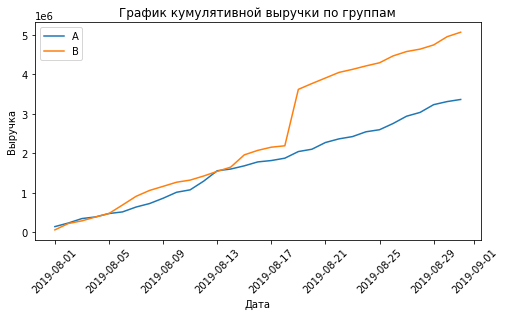

In [27]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation=45)
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('График кумулятивной выручки по группам')
plt.legend();

##### Вывод 
В первую неделю теста у группы А и группы В показатели кумулятивной выручки были почти одинаковыми, потом немного начала лидировать группа В, а ко второй неделе показатели примерно сравнялись. Но примерно на 2.5 неделю произошел резкий скачок показателя кумулятивной выручки группы В, который обеспечил лидирующие показатели группы В до конца теста. Возможно, данный скачок связан с какими-то аномально большими заказами или с аномально большим количеством заказов.

#### **2. Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.**

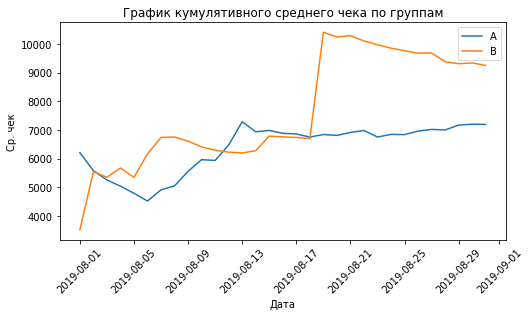

In [28]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=45)
plt.ylabel('Ср. чек')
plt.xlabel('Дата')
plt.title('График кумулятивного среднего чека по группам')
plt.legend();

##### Вывод

Графики кумулятивной выручки и кумулятивного среднего чека могут быть связанными, при условии, что нет выброса по количеству заказов. В данном случае мы можем наблюдать, что поведение кривых на графике кумулятивной выручки и кумулятивного среднего чека на протяжении всего теста похоже друг на друга, но самым интересным моментом является скачок группы В, который происходит в тот же промежуток времени, что и скачок на графике кумулятивной  выручки. 

Исходя из этого, можем сделать вывод, что скачок на графике кумулятивного среднего чека это следствие скачка на графике кумулятивной выручки. Так как в выводе выше мы предположили, что, возможно, скачок на графике кумулятивной выручки может быть:

    1) из-за аномально больших заказов
    2) из-за аномального количества заказов
    
А, так как график кумулятивного среднего чека выросла, то мы можем утверждать, что причина именно в аномально больших заказах, а не в их количестве. 

#### **3. Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.**

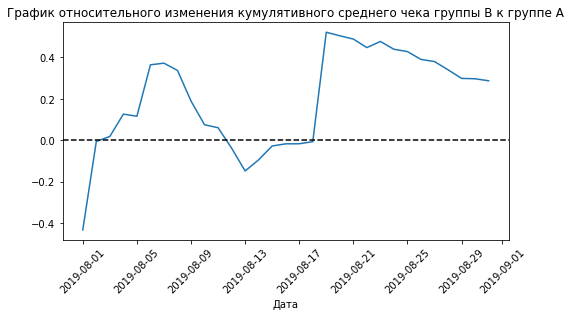

In [29]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=45);

##### Вывод
На графике относительного кумулятивного значения видно в какие даты совершались аномальные покупки

####  **4. Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.**

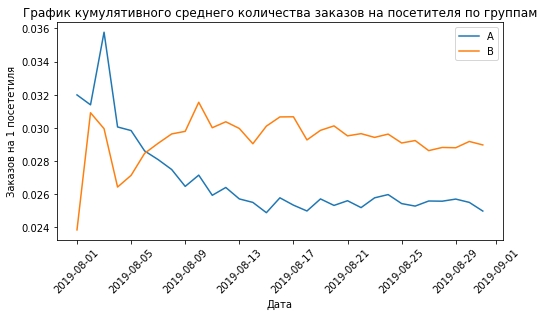

In [30]:
plt.plot(cumulativeData[cumulativeData['group'] == 'A']['date'], cumulativeData[cumulativeData['group'] == 'A']['orders'] / cumulativeData[cumulativeData['group'] == 'A']['visitors'], label='A')
plt.plot(cumulativeData[cumulativeData['group'] == 'B']['date'], cumulativeData[cumulativeData['group'] == 'B']['orders'] / cumulativeData[cumulativeData['group'] == 'B']['visitors'], label='B')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Заказов на 1 посететиля')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.legend() 

##### Вывод
В начале теста в группе A был резкий скачок в заказах, на каждые `100 просмотров` было `~ 3.6 заказа`, и это, скорее всего аномалия, дальше и до конца теста показатель только падал. В группе B тоже был резкий скачок, но к концу теста показатель  стабилизовался и держался примерно на показателе `~ 3 заказа` на каждые `100 просмотров`.

#### **5. Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.**

In [31]:
cumulativeData['conversion'] = (
    cumulativeData['orders'] / cumulativeData['visitors']
)

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

No handles with labels found to put in legend.


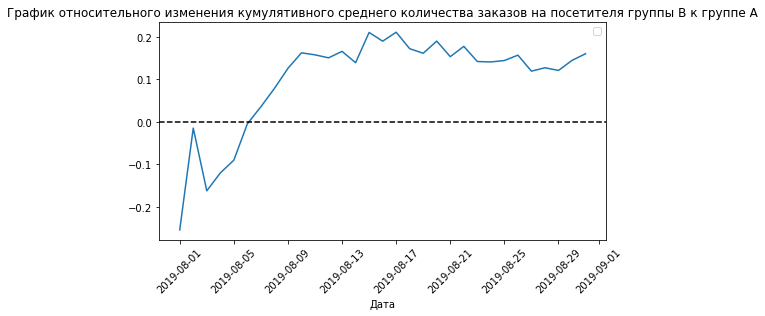

In [32]:
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.legend()
plt.xlabel('Дата')

plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45);


##### Вывод
По графику относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A видно, что ко второй неделе теста в группе B покупки совершались на `~15%` чаще, чем в группе A.

#### **6. Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.**

In [33]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,3797467345,1196621759,2019-08-15,9759,B
3,2282983706,2322279887,2019-08-15,2308,B
4,182168103,935554773,2019-08-15,2210,B


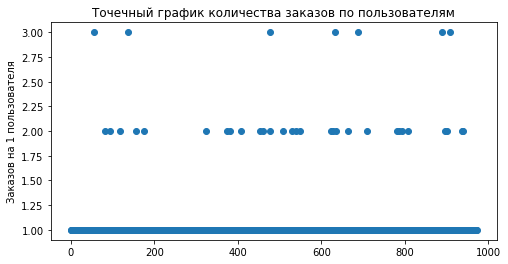

In [34]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['visitorId', 'orders']

ordersByUsers['orders'].sort_values()
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))


plt.ylabel('Заказов на 1 пользователя')
plt.title('Точечный график количества заказов по пользователям')
plt.scatter(x_values, ordersByUsers['orders']);

In [35]:
ordersByUsers_stat = ordersByUsers.groupby('orders').count().reset_index()
ordersByUsers_stat['percent'] = round(ordersByUsers_stat['visitorId'] / sum(ordersByUsers_stat['visitorId']) * 100, 2)
ordersByUsers_stat

,orders,visitorId,percent
0,1,937,96.30
1,2,29,2.98
2,3,7,0.72


##### Вывод
По графику видно, что пользователей совершивших больше `3` покупок нет, при этом пользователей совершивших `2` и более покупок очень мало, абсолютное большинство за пользователями, совершивших всего `1` покупку. 

#### **7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.**

In [36]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))

[1. 1. 2.]


##### Вывод
Границу для определения аномальных пользователей выберем `99 перцентиль`. Не более `1%` пользователей совершает больше двух заказов.

#### **8. Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.**

Text(0.5, 1.0, 'Точечный график стоимостей заказов')

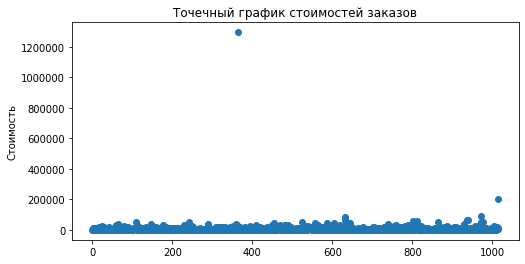

In [37]:

x_values = pd.Series(range(0, len(orders['revenue'])))
plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x * 1)))
plt.scatter(x_values, orders['revenue'])
plt.ylabel('Стоимость')
plt.title('Точечный график стоимостей заказов')




Text(0.5, 1.0, 'Точечный график стоимостей заказов')

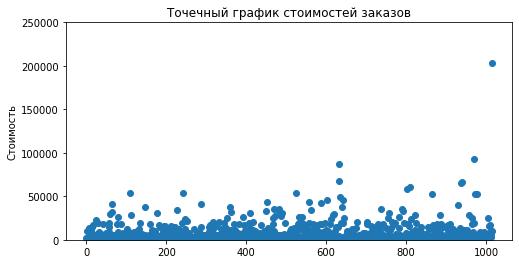

In [38]:
# посмотрим поближе
plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x * 1)))
plt.scatter(x_values, orders['revenue'])
plt.ylim(0, 250000)
plt.ylabel('Стоимость')
plt.title('Точечный график стоимостей заказов')

##### Вывод
Заказы стоимостью больше `1.2 миллиона руб`. и на `200 тыс. руб`.  выглядят странно, можно предположить, что все заказы, дороже `75 тыс. руб.` - аномалия 

#### **9. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.**

In [39]:
print(np.percentile(orders['revenue'], [90, 95, 99]))

[17990. 26785. 53904.]


##### Вывод
Не более `1%` покупателей совершает покупки на сумму больше `53904 руб`. Мне кажется оптимальная граница.

#### **10. Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.**

Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.

Будем считать, что критический уровень статистической значимости(alpha) равен `0.05`

In [41]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


In [42]:
print("{0:.5f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.01102
0.160


##### Вывод 
По сырым данных: p-value = `0.01102` меньше `0.05`. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный прирост среднего группы B к среднему группы A - `16%`

#### **11. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.**

 Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. 

In [43]:
print('{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.829
0.287


##### Вывод 
p-value больше `0.05`, значит статистически значимых отличий в среднем чеке между группами нет. Нулевую гипотезу не отвергаем. При этом относительное различие среднего чека между сегментами `28.7%`, что довольно значимо.

#### **12. Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.**

Нулевая гипотеза: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.

In [44]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,3797467345,1196621759,2019-08-15,9759,B
3,2282983706,2322279887,2019-08-15,2308,B
4,182168103,935554773,2019-08-15,2210,B


In [45]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 53904]['visitorId'] #53904
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [46]:
print('{0:.5f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.00702
0.189


##### Вывод
По не очищенным данным:

* p-value = `0.01102`
* относительный прирост среднего группы B к среднему группы A = `0.160`

По очищенным данным:

* p-value = `0.00702`
* относительный прирост среднего группы B к среднему группы A = `0.189`

По очищенным данным статистическая значимость различий в среднем количестве заказов на посетителя стала еще меньше `0.05`, следовательно, разница статистически значима. Разрыв  между группами вырос с `0.16` до `0.189`
 

#### **13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.**

 Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. 

In [47]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,3797467345,1196621759,2019-08-15,9759,B
3,2282983706,2322279887,2019-08-15,2308,B
4,182168103,935554773,2019-08-15,2210,B


In [48]:
print(
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.788
-0.032


##### Вывод

По не очищенным данным:

* p-value = `0.829`
* относительное различие среднего чека между группой B к группе A = `0.287`

По очищенным данным:

* p-value = `0.788`
* относительное различие среднего чека между группой B к группе A = `-0.032`

По очищенным данным статистическая значимость различий в среднем чеке заказов между группами немного уменьшилась, но, по прежнему больше `0.05`, следовательно, разница статистически не значима. При этом, относительное различие среднего чека между группой B и группой А стал равен `-0.032`, что говорит о том, что, неожиданно, средний чек группы А чуть-чуть выше среднего чека группы В, но, можно считать, что они почти равны.



#### **14. Примите решение по результатам теста и объясните его.**

Варианты решений:

1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест. 

По итогам A/B теста имеем:
* Присутствуют статистически значимые различия по среднему количеству заказов между группами, как по сырым данным, так и по чистым. А также разрыв в количестве заказов между группами преобладает в группе В. По сырым данным это `16%`, по очищенным `18.9%`
* Нет статистически значимого различия по среднему чеку между группами, как по сырым данным, так и по чистым. При этом, на сырых данных был сильный разрыв относительного различия среднего чека между сегментами, равный `28.7%` в пользу группы В.  На очищенных данных разрыв относительного различия среднего чека между сегментами уменьшился до `-3.2%` в пользу группы А.

Если закрыть глаза на то, что в данных группы А и В перемешались при проведении теста и исходить из выше перечисленных фактов принимаем решение остановить тест, зафиксировать победу группы В. Но, если учитывать, что группы перемешались, то я бы признал тест неудачным. 